# How to select the qubit subset to run your circuit on HW

The `BackendEvaluator` util allows you to find the best subset of qubits of a given **geometry** according to a given **metric**. This is useful to define the initial layout for the circuit transpilation to run on hardware.


## 1. Running with default settings

By default, the `BackendEvaluator` class will try to find the qubits with the best 2-qubit gate fidelity (metric) for a given backend. By default it looks for a line of qubits. Let's see this in action for 19 qubits in a fake backend.

In [1]:
# SIMULATED FAKE BACKEND
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
backend = GenericBackendV2(
    num_qubits=19, coupling_map=cmap, basis_gates=["x", "sx", "cz", "id", "rz"], seed=0
)

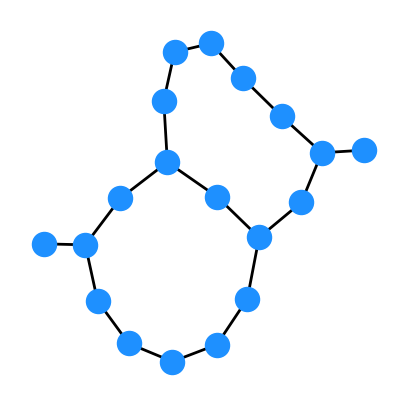

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

cmapg = nx.from_edgelist(list(cmap.get_edges()))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nx.draw(cmapg, ax=ax, width=2, node_color="dodgerblue", node_size=300)

In [3]:
from qopt_best_practices.qubit_selection import BackendEvaluator

num_qubits = 10
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)

Best path:  [2, 14, 1, 13, 0, 9, 3, 15, 11, 17]
Best path fidelity 0.9819974970192988
Num. evaluated paths 40


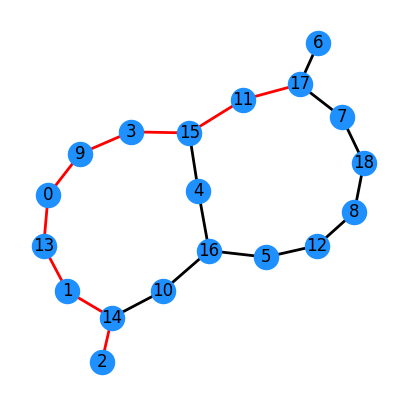

In [4]:
cmapg = nx.from_edgelist(list(cmap.get_edges()))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
edge_set = [(path[i], path[i+1]) for i in range(len(path)-1)] + [(path[i+1], path[i]) for i in range(len(path)-1)]
nx.draw(cmapg, ax = ax, edge_color=["r" if edge in edge_set else "k" for edge in cmapg.edges()], width=2, node_color="dodgerblue", node_size=300, with_labels=True)

## 2. Running with custom evaluation criteria

The evaluation criteria can also be defined by the user and given to the `BackendEvaluator` class as a callable. This requires the user to specify two callables. These callables are defined below.

1. The `subset_finder` is reposible for finding the possible sets of qubits to run on. For example, this may correspond to identifying all lines of qubits with a given length on the backend.
2. The `metric_eval` is responsible for assigning a fidelity number to each set of qubits found by the `subset_finder`. For example, based on the two-qubit gate fidelity or perhaps filtering out qubits whose measurement fidelity is not high enough.


In [5]:
from __future__ import annotations
import numpy as np
import rustworkx as rx

from qiskit.transpiler import CouplingMap


def find_lines(length: int, backend, coupling_map: CouplingMap | None = None) -> list[int]:
    """Finds all possible lines of length `length` for a specific backend topology.

    This method can take quite some time to run on large devices since there
    are many paths.

    Returns:
        The found paths.
    """

    # might make sense to make backend the only input for simplicity
    if coupling_map is None:
        if backend.version == 2:
            coupling_map = CouplingMap(backend.coupling_map)
        else:
            coupling_map = CouplingMap(backend.configuration().coupling_map)

    all_paths = rx.all_pairs_all_simple_paths(
        coupling_map.graph,
        min_depth=length,
        cutoff=length,
    ).values()

    paths = np.asarray(
        [
            (list(c), list(sorted(list(c))))
            for a in iter(all_paths)
            for b in iter(a)
            for c in iter(a[b])
        ]
    )

    # filter out duplicated paths
    _, unique_indices = np.unique(paths[:, 1], return_index=True, axis=0)
    paths = paths[:, 0][unique_indices].tolist()

    return paths

In [6]:
TWO_Q_GATES = ["cx", "ecr", "cz"]

def evaluate_fidelity(path: list[int], backend: Backend, edges) -> float:
    """Evaluates fidelity on a given list of qubits based on the two-qubit gate error
    for a specific backend.

    Returns:
       Path fidelity.
    """

    two_qubit_fidelity = {}

    if backend.version == 2:
        target = backend.target
        try:
            gate_name = list(set(TWO_Q_GATES).intersection(backend.operation_names))[0]
        except IndexError as exc:
            raise ValueError("Could not identify two-qubit gate") from exc

        for edge in edges:
            try:
                cx_error = target[gate_name][edge].error
            except:  # pylint: disable=bare-except
                cx_error = target[gate_name][edge[::-1]].error

            two_qubit_fidelity[tuple(edge)] = 1 - cx_error
    else:
        props = backend.properties()
        try:
            gate_name = list(set(TWO_Q_GATES).intersection(backend.configuration().basis_gates))[0]
        except IndexError as exc:
            raise ValueError("Could not identify two-qubit gate") from exc

        for edge in edges:
            try:
                cx_error = props.gate_error(gate_name, edge)
            except:  # pylint: disable=bare-except
                cx_error = props.gate_error(gate_name, edge[::-1])

            two_qubit_fidelity[tuple(edge)] = 1 - cx_error

    if not path or len(path) == 1:
        return 0.0

    fidelity = 1.0
    for idx in range(len(path) - 1):
        fidelity *= two_qubit_fidelity[(path[idx], path[idx + 1])]
    return fidelity

In [7]:
num_qubits = 10
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(
    num_qubits, subset_finder=find_lines, metric_eval=evaluate_fidelity
)

print("Best path: ", path)
print("Best path fidelity", fidelity)
print("Num. evaluated paths", num_subsets)


Best path:  [2, 14, 1, 13, 0, 9, 3, 15, 11, 17]
Best path fidelity 0.9819974970192988
Num. evaluated paths 40
